In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split

# Regression Networks

In [2]:
class VelocityCNN(nn.Module):
    def __init__(self):
        super(VelocityCNN, self).__init__()    
        # Define convolutional layers
        self.conv1 = nn.Conv2d(15, 16, kernel_size=7, padding=1)
        self.norm1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=1)
        self.norm2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=1)
        self.norm3 = nn.BatchNorm2d(64)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.pool = nn.MaxPool2d(2)
        
        # Define regressor
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 2 * 2, 128),  # Adjust the size based on the output from the last pooling layer
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 6)  # Output Layer for x, y coordinates and velocity
        )

    def forward(self, x):
        # Apply convolutional layers with activations, pooling and normalization
        x1 = self.conv1(x / 255.0)
        x = self.tanh(x1)
        x = self.norm1(self.pool(x))
        x2 = self.conv2(x)
        x = self.tanh(x2)
        x = self.norm2(self.pool(x))
        x3 = self.conv3(x)
        x = self.tanh(x3)
        x = self.norm3(self.pool(x))
        
        # Apply regressor
        x = self.regressor(x)
        
        return x


class LocalizationCNN(nn.Module):
    def __init__(self):
        super(LocalizationCNN, self).__init__()
        
        # Define convolutional layers
        self.conv1 = nn.Conv2d(15, 16, kernel_size=7, padding=1)
        self.norm1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=1)
        self.norm2 = nn.BatchNorm2d(32)
        
        # self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # self.norm3 = nn.BatchNorm2d(128)
        
        self.tanh = nn.Tanh()
        self.pool = nn.MaxPool2d(2)
        
        # Define regressor
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 6 * 6, 64),  # Adjust the size based on the output from the last pooling layer
            nn.tanh(),
            nn.Dropout(0.4),
            nn.Linear(64, 6)  # Output Layer for x, y, z of target and object
        )

    def forward(self, x):
        # Apply convolutional layers with activations, pooling and normalization
        x1 = self.conv1(x / 255.0)
        x = self.tanh(x1)
        x = self.norm1(self.pool(x))
        x2 = self.conv2(x)
        x = self.tanh(x2)
        x = self.norm2(self.pool(x))
        # x3 = self.conv3(x)
        # x = self.relu(x3)
        # x = self.norm3(self.pool(x))
        
        # Apply regressor
        x = self.regressor(x)
        return x


# Load and prepare the dataset
def load_data(X, Y, training_size=0.8):
    dataset = TensorDataset(X, Y)

    # Splitting dataset into training and validation
    train_size = int(training_size * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    return train_dataset, val_dataset

def train_model(model, device, train_loader, val_loader, optimizer, loss_function, epochs):
    model.train()
    training_losses = []
    validate_losses = []
    for epoch in range(epochs):
        total_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.size(0)
        training_avg_loss = total_loss / len(train_loader.dataset)
        training_losses.append(training_avg_loss) # average loss for each epoch
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_function(output, target)
            total_loss += loss.item() * data.size(0)
        validate_avg_loss = total_loss / len(val_loader.dataset)
        validate_losses.append(validate_avg_loss)
        print(f'Epoch {epoch+1}, Training Loss: {training_avg_loss:.7f}, Validation Loss: {validate_avg_loss:.7f}')
    return training_losses, validate_losses

def validate_model(model, device, val_loader, loss_function):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_function(output, target)
            total_loss += loss.item() * data.size(0)
    avg_loss = total_loss / len(val_loader.dataset)
    print(f'Validation Loss: {avg_loss:.4f}')
    return avg_loss

def plot_learning_curves(training_losses, validation_losses, start, title):
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses[start:], label='Training Loss')
    plt.plot(validation_losses[start:], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Data Checking

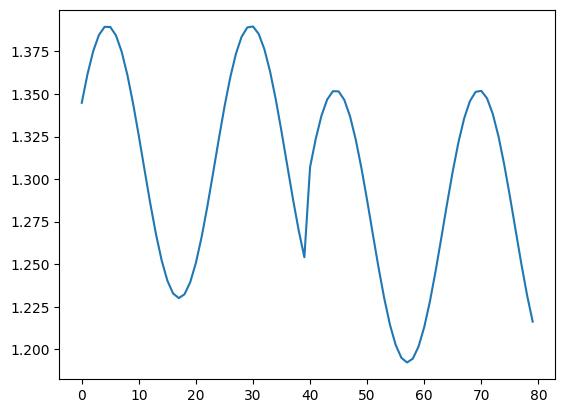

In [3]:
pos = torch.load('position_labels32.pt')
vel = torch.load('velocity_labels32.pt')

goal_pos_x = pos[:, 0]
goal_vel_x = vel[:, 0]

# plot goal position x
plt.plot(goal_pos_x[:80])

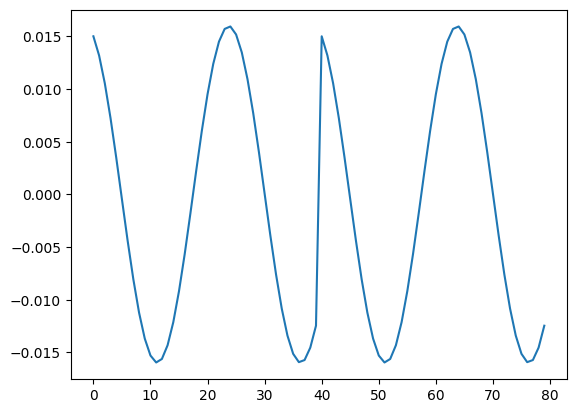

In [4]:
# plot goal velocity x
plt.plot(goal_vel_x[:80])

# Training

In [3]:
# load training data
X = torch.load('training_images32.pt')
# Y = torch.load('position_labels32.pt')
Y = torch.load('velocity_labels32.pt')
print(X.shape, Y.shape)

torch.Size([2000, 15, 32, 32]) torch.Size([2000, 6])


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
# Load data
train_dataset, val_dataset = load_data(X, Y)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [5]:
# Initialize the model and other components
model = LocalizationCNN().to(device)
# model = VelocityCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_function = nn.MSELoss()

# Training and Validation
training_losses, validate_losses = train_model(model, device, train_loader, val_loader, optimizer, loss_function, epochs=600)

Epoch 1, Training Loss: 0.0163023, Validation Loss: 0.0679417
Epoch 2, Training Loss: 0.0026256, Validation Loss: 0.0128738
Epoch 3, Training Loss: 0.0021762, Validation Loss: 0.0107774
Epoch 4, Training Loss: 0.0019907, Validation Loss: 0.0099502
Epoch 5, Training Loss: 0.0018181, Validation Loss: 0.0088705
Epoch 6, Training Loss: 0.0016046, Validation Loss: 0.0078857
Epoch 7, Training Loss: 0.0014724, Validation Loss: 0.0072667
Epoch 8, Training Loss: 0.0013796, Validation Loss: 0.0067843
Epoch 9, Training Loss: 0.0012571, Validation Loss: 0.0061695
Epoch 10, Training Loss: 0.0011414, Validation Loss: 0.0056822
Epoch 11, Training Loss: 0.0010876, Validation Loss: 0.0055070
Epoch 12, Training Loss: 0.0010502, Validation Loss: 0.0053188
Epoch 13, Training Loss: 0.0009973, Validation Loss: 0.0050174
Epoch 14, Training Loss: 0.0009007, Validation Loss: 0.0044955
Epoch 15, Training Loss: 0.0009029, Validation Loss: 0.0045249
Epoch 16, Training Loss: 0.0008425, Validation Loss: 0.0042437
E

In [6]:
np.round(Y[:100], 3)

tensor([[ 0.0150, -0.0050,  0.0000,  0.0300, -0.0110,  0.0000],
        [ 0.0130, -0.0090,  0.0000,  0.0260, -0.0180,  0.0000],
        [ 0.0110, -0.0120,  0.0000,  0.0210, -0.0240,  0.0000],
        [ 0.0070, -0.0140,  0.0000,  0.0140, -0.0280,  0.0000],
        [ 0.0030, -0.0160,  0.0000,  0.0070, -0.0310,  0.0000],
        [-0.0000, -0.0160,  0.0000, -0.0010, -0.0320,  0.0000],
        [-0.0040, -0.0150,  0.0000, -0.0090, -0.0310,  0.0000],
        [-0.0080, -0.0140,  0.0000, -0.0160, -0.0280,  0.0000],
        [-0.0110, -0.0110,  0.0000, -0.0220, -0.0230,  0.0000],
        [-0.0140, -0.0080,  0.0000, -0.0270, -0.0160,  0.0000],
        [-0.0150, -0.0050,  0.0000, -0.0310, -0.0090,  0.0000],
        [-0.0160, -0.0010,  0.0000, -0.0320, -0.0010,  0.0000],
        [-0.0160,  0.0030,  0.0000, -0.0310,  0.0070,  0.0000],
        [-0.0140,  0.0070,  0.0000, -0.0290,  0.0140,  0.0000],
        [-0.0120,  0.0100,  0.0000, -0.0240,  0.0210,  0.0000],
        [-0.0090,  0.0130,  0.0000, -0.0

In [11]:
np.round(model(X[:100]), 3)

tensor([[ 0.0080, -0.0080,  0.0000,  0.0170, -0.0160,  0.0000],
        [ 0.0190, -0.0040, -0.0000,  0.0370, -0.0070, -0.0000],
        [ 0.0150, -0.0040, -0.0000,  0.0300, -0.0090, -0.0000],
        [ 0.0060, -0.0170,  0.0000,  0.0120, -0.0350, -0.0000],
        [-0.0040, -0.0040,  0.0000, -0.0080, -0.0070,  0.0000],
        [-0.0040, -0.0040,  0.0000, -0.0080, -0.0070,  0.0000],
        [-0.0020, -0.0040,  0.0000, -0.0050, -0.0080,  0.0000],
        [-0.0070, -0.0140,  0.0000, -0.0130, -0.0280,  0.0000],
        [-0.0080, -0.0020,  0.0000, -0.0160, -0.0040,  0.0000],
        [-0.0110, -0.0090,  0.0000, -0.0230, -0.0190,  0.0000],
        [-0.0130, -0.0000,  0.0000, -0.0270, -0.0000,  0.0000],
        [-0.0140,  0.0000,  0.0000, -0.0280,  0.0000,  0.0000],
        [-0.0140,  0.0050,  0.0000, -0.0290,  0.0100,  0.0000],
        [-0.0040, -0.0040,  0.0000, -0.0080, -0.0070,  0.0000],
        [-0.0110,  0.0110,  0.0000, -0.0230,  0.0220,  0.0000],
        [-0.0070,  0.0140,  0.0000, -0.0

Text(0.5, 1.0, 'Original and Predicted Values for 32 x 32 Localisation CNN')

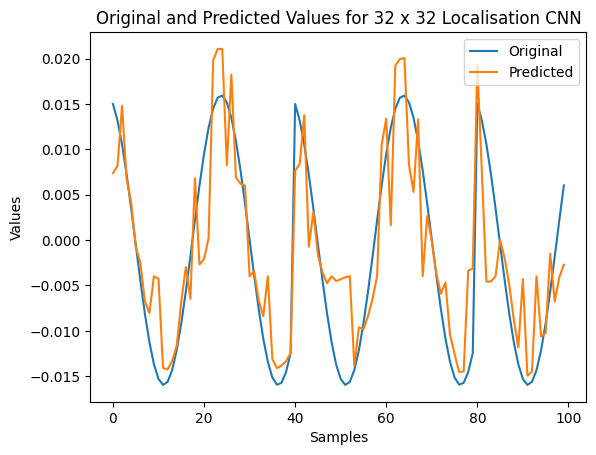

In [17]:
original = Y
predicted = model(X).detach().numpy()

# plot original and predicted values
plt.plot(original[:100, 0], label='Original')
plt.plot(predicted[:100, 0], label='Predicted')

# add legends
plt.legend(loc='upper right')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Original and Predicted Values for 32 x 32 Localisation CNN')

In [64]:
# Save the trained model
torch.save(model.state_dict(), 'localization_cnn32.pt')

In [42]:
# Save the trained model
torch.save(model.state_dict(), 'velocity_cnn32.pt')

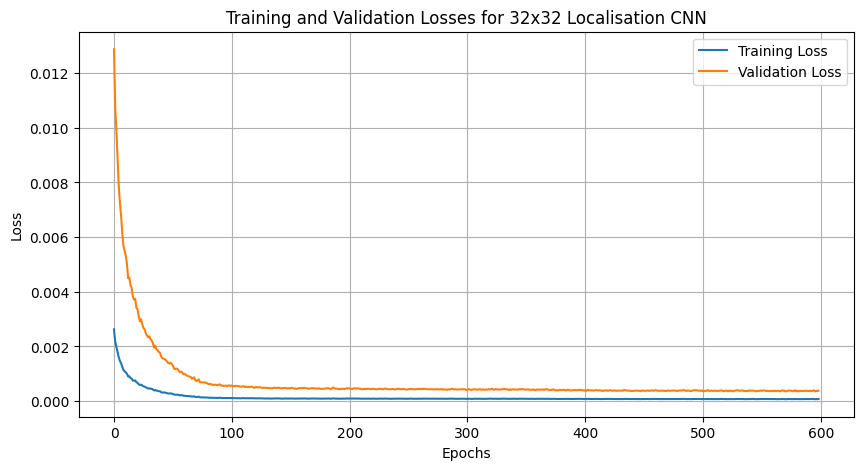

In [18]:
# Plot the learning curves
plot_learning_curves(training_losses, validate_losses, 1, 'Training and Validation Losses for 32x32 Localisation CNN')

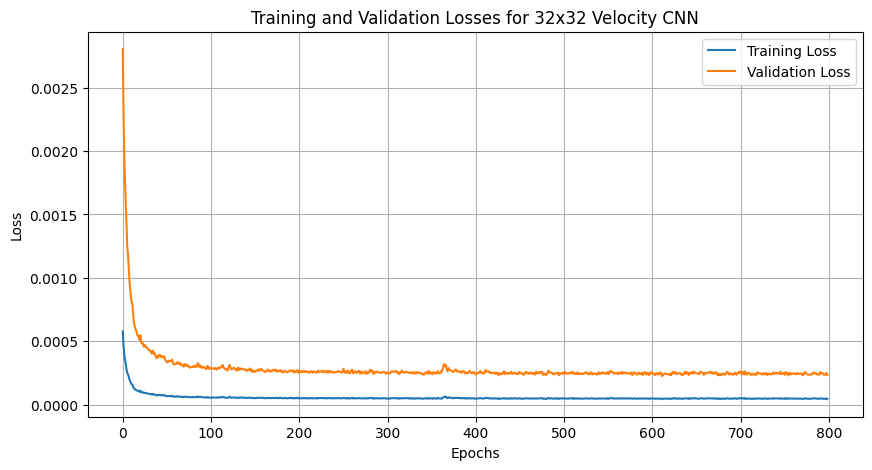

In [45]:
# Plot the learning curves
plot_learning_curves(training_losses, validate_losses, 1, 'Training and Validation Losses for 32x32 Velocity CNN')

In [19]:
# save the training and validation losses
np.save('loc_training_losses32.npy', training_losses)
np.save('loc_validate_losses32.npy', validate_losses)

In [46]:
# save the training and validation losses
np.save('vel_training_losses32.npy', training_losses)
np.save('vel_validate_losses32.npy', validate_losses)